#Trotter project

In [10]:
!pip install qiskit
!pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 4.9 MB/s 
     |████████████████████████████████| 19.2 MB 1.2 MB/s 
     |████████████████████████████████| 240 kB 53.9 MB/s 
     |████████████████████████████████| 106 kB 64.0 MB/s 
     |████████████████████████████████| 55 kB 3.5 MB/s 
     |████████████████████████████████| 50 kB 6.2 MB/s 
     |████████████████████████████████| 37.5 MB 1.2 MB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 
     |████████████████████████████████| 943 kB 57.5 MB/s 
     |████████████████████████████████| 4.1 MB 42.3 MB/s 
     |████████████████████████████████| 1.9 MB 33.0 MB/s 
     |████████████████████████████████| 112 kB 59.4 MB/s 
  Created wheel for qiskit: filename=qiskit-0.39.2-py3-none-any.whl size=12224 sha256=86fb98f07a98042d3f3e38b353096a507874a1ee1d14395bd196a48f82abdc8d
  Stored in directory: /root/.cache/pip/wheels/30/dc/90/0ee55

In [11]:
import qiskit
from qiskit import execute
import numpy as np
from qiskit.opflow import I, X, Y, Z, MatrixEvolution, PauliTrotterEvolution
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit.compiler import transpile
from qiskit.visualization import *
import pylatexenc
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, Aer, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.quantum_info import Statevector

#Matrix Representation

In [12]:
a = np.array([[0, np.sqrt(1),0,0,0,0,0,0,0,0],
             [0, 0,np.sqrt(2),0,0,0,0,0,0,0],
             [0, 0,0,np.sqrt(3),0,0,0,0,0,0],
             [0, 0,0,0,np.sqrt(4),0,0,0,0,0],
             [0, 0,0,0,0,np.sqrt(5),0,0,0,0],
             [0, 0,0,0,0,0,np.sqrt(6),0,0,0],
             [0, 0,0,0,0,0,0,np.sqrt(7),0,0],
             [0, 0,0,0,0,0,0,0,np.sqrt(8),0],
             [0, 0,0,0,0,0,0,0,0,np.sqrt(9)],
             [0, 0,0,0,0,0,0,0,0,0]])

a_dagger = np.array([[0, 0,0,0,0,0,0,0,0,0],
             [np.sqrt(1), 0,0,0,0,0,0,0,0,0],
             [0, np.sqrt(2),0,0,0,0,0,0,0,0],
             [0, 0,np.sqrt(3),0,0,0,0,0,0,0],
             [0, 0,0,np.sqrt(4),0,0,0,0,0,0],
             [0, 0,0,0,np.sqrt(5),0,0,0,0,0],
             [0, 0,0,0,0,np.sqrt(6),0,0,0,0],
             [0, 0,0,0,0,0,np.sqrt(7),0,0,0],
             [0, 0,0,0,0,0,0,np.sqrt(8),0,0],
             [0, 0,0,0,0,0,0,0,np.sqrt(9),0]])

x = a + a_dagger
p = a - a_dagger
H = a_dagger@a + 1/2*np.identity(10)

In [13]:
#Number of qubits
num_qubits = 2
#Number of ancillary qubits
num_anc = num_qubits-1 if num_qubits!=2 else 2
#Size of Hilbert space
N = (2**num_qubits)
#Time
t = np.pi * 1.8

In [14]:
#X operator 
Xd = np.zeros(shape=(N,N))
for i in range(N):
  Xd[i][i] = (-N + 2*i)/2
Xd = np.sqrt(np.pi/(2*N))*Xd

In [15]:
#Defining phases and removing  global phase from binary |0> state
Xd_=Xd@Xd
exponents = np.zeros(N)
for i in range(N):
  if i==0:
    exponents[i] = (Xd_[i][i]*0.5*t)-(Xd_[0][0]*0.5*t)
  else:
    exponents[i] = (Xd_[i][i]*-0.5*t)-(Xd_[0][0]*-0.5*t)

In [16]:
def binary_convert(Num,n):
  s = bin(Num)[2:]
  s = '0'*(n-len(s)) + s
  return s

In [17]:
def U_x(qc,n):
  #Adding the basis states to iterate through
  basis_states = []
  for i in range(2**n):
    basis_states.append(binary_convert(i,n))
  #Adding the filters
  qc.barrier()
  for k,i in enumerate(basis_states[1:]):
    Xgate_index=[]
    phase_target=0
    #Keeping track of the indexes where Xgates are used and converting the state to |1> in the case when the condition is satisfied
    for index,j in enumerate(i):
      if (j=='1'):
        phase_target=index
      if j == '0':
        Xgate_index.append(index)
        qc.x(index)
    #Applying toffoli gates 
    qc.ccx(0, 1, n)
    init_control=2 if num_qubits!=2 else 1
    init_target=n+1
    count=0
    if(n==2):
      count=1
    else:
      count=n-2
    for i in range(count):
      qc.ccx(init_control,init_target-1,init_target) #2 , 2 , 3
      init_control+=1
      init_target+=1
    #Adding the cU1 gate
    phase=exponents[k+1]
    phase_control = 2*n-2 if n!=2 else 3
    qc.cp(phase,phase_control,phase_target)
    #Adding the second set of toffoli gates
    init_control=n-1
    init_target=n+num_anc-1
    for i in range(count):
      qc.ccx(init_control,init_target-1,init_target)
      init_control-=1
      init_target-=1
    qc.ccx(0,1,n)
    #Reversing the initially applied X gates
    for i in Xgate_index:
      qc.x(i)
    qc.barrier()

In [18]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

In [19]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    # swap_registers(circuit, n)
    return circuit

In [20]:
def inverse_qft(qc, n):
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    qc.append(invqft_circ, qc.qubits[:n])
    return qc.decompose()

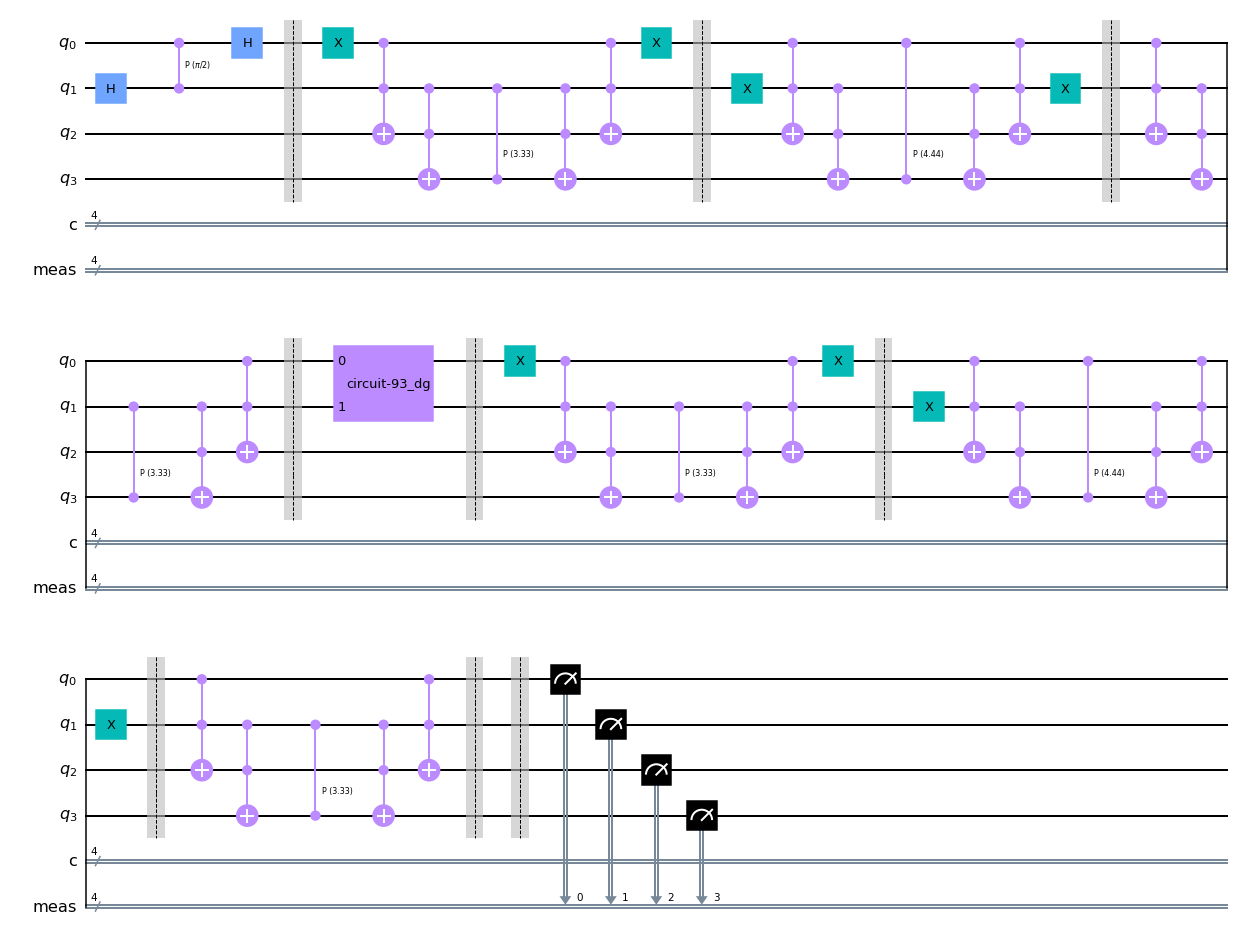

In [21]:
qc = QuantumCircuit(num_qubits+num_anc,num_qubits+num_anc)
qft(qc,num_qubits)
U_x(qc,num_qubits)
inverse_qft(qc,num_qubits)
U_x(qc,num_qubits)
# time = 10
# qc = qc.bind_parameters({t:time})
qc.measure_all()
qc.draw('mpl')

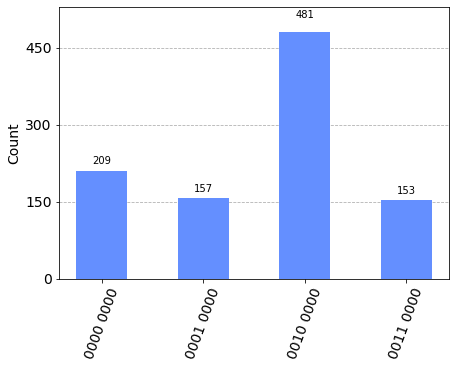

In [22]:
backend = Aer.get_backend("qasm_simulator")

# Execute the circuit on the backend 1000 times.
job = execute(qc, backend=backend, shots=1000)

# Retrieve the stats of each of the 1000 runs of the circuit
counts = job.result().get_counts()
plot_histogram(counts)